# Extract hidden topics from yelp restaurant reviews using LDA

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import numpy as np
import gensim
from gensim import corpora, similarities, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os.path

## 1. load the data from yelp database

### Load yelp_business

In [3]:
my_path = os.path.abspath(os.path.dirname("__file__"))

In [4]:
path = os.path.join(my_path, "yelp_business.csv")
with open(path) as f:
    yelp_business = pd.read_csv(f)

yelp_business.head()

business_id                        name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg          "Dental by Design"          NaN   
1  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"          NaN   
2  KQPW8lFf1y5BT2MxiSZ3QA     "Western Motor Vehicle"          NaN   
3  8DShNS-LuFqpEWIp0HxijA          "Sports Authority"          NaN   
4  PfOCPjBrlQAnz__NXj9h_w  "Brick House Tavern + Tap"          NaN   

                            address            city state postal_code  \
0        "4855 E Warner Rd, Ste B9"       Ahwatukee    AZ       85044   
1              "3101 Washington Rd"        McMurray    PA       15317   
2          "6025 N 27th Ave, Ste 1"         Phoenix    AZ       85017   
3  "5000 Arizona Mills Cr, Ste 435"           Tempe    AZ       85282   
4                    "581 Howe Ave"  Cuyahoga Falls    OH       44221   

    latitude   longitude  stars  review_count  is_open  \
0  33.330690 -111.978599    4.0            22        1   
1  40.291685  -80.104900    3.0            11        1   
2  33.524903 -112.115310    1.5            18        1   
3  33.383147 -111.964725    3.0             9        0   
4  41.119535  -81.475690    3.5           116        1   

                                          categories  
0  Dentists;General Dentistry;Health & Medical;Or...  
1  Hair Stylists;Hair Salons;Men's Hair Salons;Bl...  
2  Departments of Motor Vehicles;Public Services ...  
3                            Sporting Goods;Shopping  
4  American (New);Nightlife;Bars;Sandwiches;Ameri...

In [5]:
yelp_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174567 entries, 0 to 174566
Data columns (total 13 columns):
business_id     174567 non-null object
name            174567 non-null object
neighborhood    68015 non-null object
address         174567 non-null object
city            174566 non-null object
state           174566 non-null object
postal_code     173944 non-null object
latitude        174566 non-null float64
longitude       174566 non-null float64
stars           174567 non-null float64
review_count    174567 non-null int64
is_open         174567 non-null int64
categories      174567 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 17.3+ MB


### Select businesses which category is "restaurant"

In [6]:
yelp_business['categories'].value_counts()

Restaurants;Pizza                                                                                                           990
Pizza;Restaurants                                                                                                           987
Food;Coffee & Tea                                                                                                           978
Nail Salons;Beauty & Spas                                                                                                   936
Coffee & Tea;Food                                                                                                           929
Beauty & Spas;Nail Salons                                                                                                   909
Mexican;Restaurants                                                                                                         906
Restaurants;Mexican                                                                                     

In [7]:
yelp_business_restaurant = yelp_business[yelp_business['categories'].str.match('Restaurants')]
yelp_business_restaurant.head()

business_id                          name neighborhood  \
14  fNMVV_ZX7CJSDWQGdOM8Nw  "Showmars Government Center"       Uptown   
30  nbhBRhZtdaZmMMeb2i02pg             "Sunnyside Grill"          NaN   
44  BnuzcebyB1AfxH0kjNWqSg    "Carrabba's Italian Grill"          NaN   
55  c_XbaJqhm-5ycSBOkVUBmg                    "Don Taco"  Ville-Marie   
57  spDZkD6cp0JUUm6ghIWHzA                   "Kitchen M"   Unionville   

                                      address       city state postal_code  \
14                             "600 E 4th St"  Charlotte    NC       28202   
30                    "2777 Steeles Avenue W"    Toronto    ON     M3J 3K5   
44                        "245 Lancaster Ave"     Frazer    PA       19355   
55  "1855 Rue Saint Catherine Ouest, H3H 1M2"   Montreal    QC     H3H 1M2   
57                        "8515 McCowan Road"    Markham    ON     L3P 5E5   

     latitude  longitude  stars  review_count  is_open  \
14  35.221647 -80.839345    3.5             7        1   
30  43.781816 -79.490433    5.0             3        1   
44  40.041003 -75.542497    3.5            25        0   
55  45.493216 -73.580379    3.5            33        1   
57  43.867918 -79.283687    3.0            80        1   

                            categories  
14  Restaurants;American (Traditional)  
30      Restaurants;Breakfast & Brunch  
44         Restaurants;Italian;Seafood  
55                 Restaurants;Mexican  
57                 Restaurants;Chinese

In [8]:
yelp_business_restaurant.shape

(17842, 13)

### Load yelp_review

In [9]:
path = os.path.join(my_path, "yelp_review.csv")
with open(path) as f:

    yelp_review = pd.read_csv(f)
    
yelp_review.head()

review_id                 user_id             business_id  \
0  vkVSCC7xljjrAI4UGfnKEQ  bv2nCi5Qv5vroFiqKGopiw  AEx2SYEUJmTxVVB18LlCwA   
1  n6QzIUObkYshz4dz2QRJTw  bv2nCi5Qv5vroFiqKGopiw  VR6GpWIda3SfvPC-lg9H3w   
2  MV3CcKScW05u5LVfF6ok0g  bv2nCi5Qv5vroFiqKGopiw  CKC0-MOWMqoeWf6s-szl8g   
3  IXvOzsEMYtiJI0CARmj77Q  bv2nCi5Qv5vroFiqKGopiw  ACFtxLv8pGrrxMm6EgjreA   
4  L_9BTb55X0GDtThi6GlZ6w  bv2nCi5Qv5vroFiqKGopiw  s2I_Ni76bjJNK9yG60iD-Q   

   stars        date                                               text  \
0      5  2016-05-28  Super simple place but amazing nonetheless. It...   
1      5  2016-05-28  Small unassuming place that changes their menu...   
2      5  2016-05-28  Lester's is located in a beautiful neighborhoo...   
3      4  2016-05-28  Love coming here. Yes the place always needs t...   
4      4  2016-05-28  Had their chocolate almond croissant and it wa...   

   useful  funny  cool  
0       0      0     0  
1       0      0     0  
2       0      0     0  
3       0      0     0  
4       0      0     0

In [10]:
yelp_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261668 entries, 0 to 5261667
Data columns (total 9 columns):
review_id      object
user_id        object
business_id    object
stars          int64
date           object
text           object
useful         int64
funny          int64
cool           int64
dtypes: int64(4), object(5)
memory usage: 361.3+ MB


### Join yelp_business and yelp_reviews

In [11]:
yelp_restaurant_reviews = pd.merge(yelp_business_restaurant, yelp_review, on='business_id', how='left')
yelp_restaurant_reviews.head()

business_id                          name neighborhood  \
0  fNMVV_ZX7CJSDWQGdOM8Nw  "Showmars Government Center"       Uptown   
1  fNMVV_ZX7CJSDWQGdOM8Nw  "Showmars Government Center"       Uptown   
2  fNMVV_ZX7CJSDWQGdOM8Nw  "Showmars Government Center"       Uptown   
3  fNMVV_ZX7CJSDWQGdOM8Nw  "Showmars Government Center"       Uptown   
4  fNMVV_ZX7CJSDWQGdOM8Nw  "Showmars Government Center"       Uptown   

          address       city state postal_code   latitude  longitude  stars_x  \
0  "600 E 4th St"  Charlotte    NC       28202  35.221647 -80.839345      3.5   
1  "600 E 4th St"  Charlotte    NC       28202  35.221647 -80.839345      3.5   
2  "600 E 4th St"  Charlotte    NC       28202  35.221647 -80.839345      3.5   
3  "600 E 4th St"  Charlotte    NC       28202  35.221647 -80.839345      3.5   
4  "600 E 4th St"  Charlotte    NC       28202  35.221647 -80.839345      3.5   

   ...   is_open                          categories               review_id  \
0  ...         1  Restaurants;American (Traditional)  dd2MuvdqU5YB4Y7cYMUR9Q   
1  ...         1  Restaurants;American (Traditional)  h1loJz7i2I59whp1Csbv_Q   
2  ...         1  Restaurants;American (Traditional)  mLCqrNt1UfgS0fk28TQ1wg   
3  ...         1  Restaurants;American (Traditional)  eN0h2sxmtoc2Az0pKnrEVA   
4  ...         1  Restaurants;American (Traditional)  zhfDbWGiAh8deoqHQY_1mA   

                  user_id stars_y        date  \
0  qUL3CdRRF1vedNvaq06rIA       3  2013-04-03   
1  xAn9rQHLv_-i3NEhpg0meA       3  2016-08-17   
2  WcVh8MSyRk1guSBpHdptlw       4  2011-07-15   
3  MowgkrZB_wvC5GimuXiF6w       4  2010-10-22   
4  lV21MwucXDdG35AicQWldw       4  2016-02-28   

                                                text useful  funny  cool  
0  After craving a Greek Salad all morning, I was...      0      0     0  
1  Since its renovation last month, things are lo...      1      0     0  
2  Great place to grab a quick bite before a meet...      0      0     0  
3  You've gotta get the fried fish sandwich! Whil...      4      4     4  
4  Convenient and cheap eats if you work around t...      0      0     0  

[5 rows x 21 columns]

In [12]:
yelp_restaurant_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897114 entries, 0 to 897113
Data columns (total 21 columns):
business_id     897114 non-null object
name            897114 non-null object
neighborhood    449055 non-null object
address         897114 non-null object
city            897114 non-null object
state           897114 non-null object
postal_code     896784 non-null object
latitude        897114 non-null float64
longitude       897114 non-null float64
stars_x         897114 non-null float64
review_count    897114 non-null int64
is_open         897114 non-null int64
categories      897114 non-null object
review_id       897114 non-null object
user_id         897114 non-null object
stars_y         897114 non-null int64
date            897114 non-null object
text            897114 non-null object
useful          897114 non-null int64
funny           897114 non-null int64
cool            897114 non-null int64
dtypes: float64(3), int64(6), object(12)
memory usage: 150.6+ MB


### select useful columns

In [13]:
yelp_restaurant_reviews_selected = yelp_restaurant_reviews.iloc[:, [0, 1, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20]]
yelp_restaurant_reviews_selected.head()

business_id                          name  stars_x  \
0  fNMVV_ZX7CJSDWQGdOM8Nw  "Showmars Government Center"      3.5   
1  fNMVV_ZX7CJSDWQGdOM8Nw  "Showmars Government Center"      3.5   
2  fNMVV_ZX7CJSDWQGdOM8Nw  "Showmars Government Center"      3.5   
3  fNMVV_ZX7CJSDWQGdOM8Nw  "Showmars Government Center"      3.5   
4  fNMVV_ZX7CJSDWQGdOM8Nw  "Showmars Government Center"      3.5   

   review_count                          categories               review_id  \
0             7  Restaurants;American (Traditional)  dd2MuvdqU5YB4Y7cYMUR9Q   
1             7  Restaurants;American (Traditional)  h1loJz7i2I59whp1Csbv_Q   
2             7  Restaurants;American (Traditional)  mLCqrNt1UfgS0fk28TQ1wg   
3             7  Restaurants;American (Traditional)  eN0h2sxmtoc2Az0pKnrEVA   
4             7  Restaurants;American (Traditional)  zhfDbWGiAh8deoqHQY_1mA   

                  user_id  stars_y  \
0  qUL3CdRRF1vedNvaq06rIA        3   
1  xAn9rQHLv_-i3NEhpg0meA        3   
2  WcVh8MSyRk1guSBpHdptlw        4   
3  MowgkrZB_wvC5GimuXiF6w        4   
4  lV21MwucXDdG35AicQWldw        4   

                                                text  useful  funny  cool  
0  After craving a Greek Salad all morning, I was...       0      0     0  
1  Since its renovation last month, things are lo...       1      0     0  
2  Great place to grab a quick bite before a meet...       0      0     0  
3  You've gotta get the fried fish sandwich! Whil...       4      4     4  
4  Convenient and cheap eats if you work around t...       0      0     0

In [14]:
yelp_restaurant_reviews_selected.size

10765368

### Spliting dataset into 3 dataset

1. Select df1 for LDA model
2. Select df2_1 for Frequency Filter LDA model
3. Select df2_2 for POS Tag Filter LDA model

In [15]:
# Select df1 for LDA model
from sklearn.utils import shuffle

df1, df2 = train_test_split(yelp_restaurant_reviews_selected, test_size=0.5, random_state=58)

In [16]:
df1.size

5382684

In [17]:
# select a review used for predict
predict_sampe = df1.iloc[[0]]

In [18]:
index_1 = predict_sampe.index

In [19]:
index_1.values[0]

371131

In [144]:
# delete the selected review from original df1
df1.drop([index_1.values[0]], inplace = True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
# Select df2_1 and df2_2
df2_1, df2_2 = train_test_split(df2, test_size=0.5, random_state=58)

1) df2_1 

In [146]:
improve_sampe_1 = df2_1.iloc[[0]]

In [147]:
improve_sampe_1

business_id           name  stars_x  review_count  \
698507  3_A59jPniLD5ViVuKMYpJw  "Acacia Cafe"      4.0           217   

                                               categories  \
698507  Restaurants;Sandwiches;Food;Breakfast & Brunch...   

                     review_id                 user_id  stars_y  \
698507  e2vcEBZPRjtJxyg7puSTCw  97HBmb3aWneJ3pU3-2Xi3A        5   

                                                     text  useful  funny  cool  
698507  This is one of the best family morning spots i...       1      0     0

In [148]:
index_2 = improve_sampe_1.index

In [149]:
df2_1.drop([index_2.values[0]], inplace = True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


2) df2_2

In [150]:
improve_sampe_2 = df2_2.iloc[[0]]

In [151]:
improve_sampe_2

business_id               name  stars_x  review_count  \
519085  cxnbk6t6L3jnfT5n2Hbl3Q  "SinCity Burgers"      3.0            71   

                 categories               review_id                 user_id  \
519085  Restaurants;Burgers  uTveit2GbM-_L8XJ_YKBsw  jJUbS-15mERkj442JZrFDQ   

        stars_y                                               text  useful  \
519085        4  Positively Sinful!!!! This is NOT diet food! M...       0   

        funny  cool  
519085      0     0

In [152]:
index_2 = improve_sampe_2.index

In [153]:
index_2

Int64Index([519085], dtype='int64')

In [154]:
df2_2.drop([index_2.values[0]], inplace = True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 2. Exploring the dataset

### 1) Explore the relationship among 'stars', 'useful', 'funny', 'cool'

In [155]:
stars = yelp_restaurant_reviews_selected.groupby('stars_y').mean()
stars.corr()

stars_x  review_count    useful     funny      cool
stars_x       1.000000      0.996660 -0.917465 -0.960399  0.778786
review_count  0.996660      1.000000 -0.935319 -0.968987  0.741235
useful       -0.917465     -0.935319  1.000000  0.978875 -0.574358
funny        -0.960399     -0.968987  0.978875  1.000000 -0.607870
cool          0.778786      0.741235 -0.574358 -0.607870  1.000000

Show the heat map

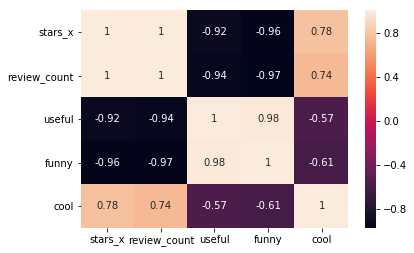

In [156]:
sns.heatmap(data=stars.corr(), annot=True)

As we can see, 'stars' is strongly correlated with 'cool' and has a negative correlation with 'useful' and 'funny'. There is a strong correlation between 'useful' and 'funny'.

### 2) Explore different stars distribution among different categories

In [72]:
yelp_business_restaurant['categories'].value_counts()

Restaurants;Pizza                                                                                990
Restaurants;Mexican                                                                              864
Restaurants;Chinese                                                                              857
Restaurants;Italian                                                                              615
Restaurants                                                                                      362
Restaurants;American (Traditional)                                                               311
Restaurants;Thai                                                                                 274
Restaurants;Fast Food                                                                            259
Restaurants;Sandwiches                                                                           244
Restaurants;Burgers                                                                        

In [15]:
yelp_categories_selected = yelp_business_restaurant[yelp_business_restaurant['categories'].isin(['Restaurants;Pizza', 'Restaurants;Mexican', 'Restaurants;Chinese', 'Restaurants;Italian', 'Restaurants;American (Traditional)', 'Restaurants;Thai', 'Restaurants;Fast Food'])]

Show different stars distribution among categories

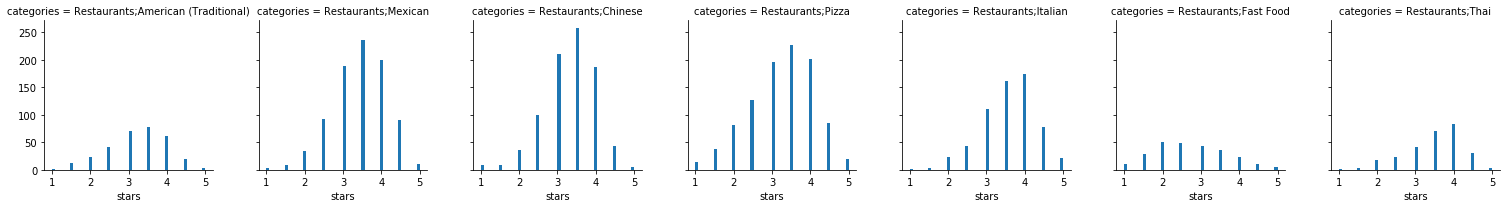

In [16]:
yelp_categories = sns.FacetGrid(data=yelp_categories_selected, col='categories')
yelp_categories.map(plt.hist, 'stars', bins=50)

As we can see, fast food is a right-skewed distribution. Others are left_skewed distributions.

## 3. clean the data

### Sample the data (or they will run forever)

In [21]:
df1.sample(n=1000, replace = True)

business_id                                      name  \
279524  8T5JnB9qL5y8RaCHH5zKSQ                      "Bean Vegan Cuisine"   
477531  w5ThjiIgIZCGkUARSWP5Fw                    "Thai Classic Cuisine"   
460331  fL-b760btOaGa85OJ9ut3w                   "Rollin Smoke Barbeque"   
476866  KhvuMJpYNNySVxsu2o1eqg              "Geisha House Steak & Sushi"   
296339  fMt-wU8Topyja7u9qPJaqQ                               "Yummy Pho"   
152160  n-iHDxbFrNQoNIpt5TjiNg                                  "Subway"   
553726  elqbBhBfElMNSrjFqW3now                "Pin Kaow Thai Restaurant"   
42240   YRyYbOSwvHkZsZOLv98oQg                        "Estiatorio Milos"   
527738  iHepzMP8-9_AXPS-u7tolg                 "Amazing Thai Restaurant"   
92417   J4jxIxv_vgmWHCajos_B8w                   "Taza A Lebanese Grill"   
54994   Z8f5s3BsMzveANqdbFjXLg                  "Azure Restaurant & Bar"   
400944  8fFTJBh0RB2EKG53ibiBKw                          "Zenaida's Cafe"   
669352  3fT1kcQ-MVEImGHa3hll5w                        "Earl of Sandwich"   
339112  LYoWpJNZu3brsEt9QY8KRg                      "Smoke's Burritorie"   
411826  iJCI80Nwp514xIqBOgjhCA                               "Fat Pasha"   
358944  w2tr0PA0b3tg8pId0kjM-A                           "Gaby Et Jules"   
791400  Xg5qEQiB-7L6kGJ5F4K3bQ                         "Little Miss BBQ"   
820975  uwBJlA27pNywYTlPBiSqVw                          "Overlook Grill"   
412378  4JkGjRRc3XucG9U8XwthGg                           "China Gourmet"   
489657  fFInb4Dl2Ix4iE-VOltbkQ                                  "Verses"   
543709  5zDP3Y2hdh6GJL9DVbQ2KA         "Ventano Italian Grill & Seafood"   
500231  RKVYQ00LvK0_FO6Ll7lvOg                 "Muddy Waters Oyster Bar"   
396568  r8wqayijZLPd7XPuypLayA                            "Kuljit India"   
881173  N7yuiiu8jhQ-Fl9Npflreg                              "Lemongrass"   
252483  Z3ZSar8IVAR2qIupqxMynA                    "Joe's New York Pizza"   
457046  YWRn5UF4Fdxo59Vu__t_Fw                   "Tomori's Pizza & Subs"   
455645  cjxPOPcFkpq0cspQ2cHL8w  "El Charro Restaurant & Cocktail Lounge"   
495760  uhyDNWYRSsom3VrFgOgP_w                              "Greka Pita"   
852220  Q8EwiqPZiheEQH0S66THEg                          "Chako Barbeque"   
835778  qnn9E-e9orYf_wK37yLTYw                  "Blanco Tacos + Tequila"   
...                        ...                                       ...   
770780  mBOIef7a4hONEbSi_ai8Bw                                   "Beast"   
442302  03DvzzcB5ze7lacYwZbH8A                           "Dr Generosity"   
441659  2px99IppAcnxR238eq_8_w                              "Big Buddha"   
570175  idWdWF7We8XaOWDrSHiDoQ                        "Pamika Brasserie"   
68748   TU2Vt9nRhVSBMVTAivy9Ug            "Coney Island Gourmet Hotdogs"   
251025  vK1_qKEG7zHvjiTOsN0CRg                     "Snooze An AM Eatery"   
481360  E3uHQoBN3djCRHSBg8RrdA                         "Mamie Clafoutis"   
494877  LpEN6lnHYe5zfiaNQ1XNLw                               "Lilavadee"   
675546  3QBI8R6Aa52Thc38MvTXiA                       "La Maison Bulgogi"   
438753  6eCbK0Fg9N_DbdluVQx-pA                               "Sushi Ave"   
702202  Dq7Vco6wVC_MPj11pDWu8w                          "Harry Ramsdens"   
596547  tPyKZPLJ-Wrm4CrEJbxFuA                          "DiBella's Subs"   
158844  EUxbuNT8BYPs_h0vVMy2pg                 "Don Pancho Mexican Food"   
554321  53jjJCXpXSRaHfu_ZJePRA                             "Joe's Diner"   
378680  Rd11Bosr8JkfoUhZLzpuxg                      "The Capital Grille"   
268505  g8OnV26ywJlZpezdBnOWUQ                      "Hash House A Go Go"   
157803  F9_VdKmPyvEcqWSVVGkNNA                      "Hurley's Irish Pub"   
120382  C3gKBIsZKR3bp43BbOu8qA                               "Thai Rama"   
128579  5shgJB7a-2_gdnzc0gsOtg                                 "Firefly"   
521019  b4LmLgVdbhM-nc1IZc5Weg                   "Rodney's Oyster House"   
744719  RAh9WCQAuocM7hYM5_6tnw            "The Cowfish Sushi Burger

In [22]:
df2_1.sample(n=1000, replace = True)

business_id  \
682909  ICdoTODBaprN0UReete9VQ   
382517  NwWYSYGHFyHQMmsXu0SiYA   
856055  _9vGmNrEcLWFOnUzeUdfag   
788339  QScgA7P2HK4oacPKL6bgDg   
351544  urH0YHSjB3z8ogUJDJWJPA   
861272  z5J9U_HU4iVLwaCH6rdC2w   
212300  8HycRNzRmhwEkZiMD8X9kw   
148685  PC_bg7yJTuRQbR5K8W5S5Q   
147561  APPZiUz_CEvR_--qY-tbig   
143605  k1c_bC3DK6mKg797vH1T8w   
464488  NQhPS0MUKJgBUB6PTLlmzA   
768505  tul3gM5M1bLmf4I-6EHCBg   
696093  JpgVl3d20CMRNjf1DVnzGA   
622919  gugN1sgyheBJ6aKtNcv_gQ   
569190  cAs1-wyAjvfsK1Vgo1jCWA   
735721  Qu9erGSYgH4ljIbJLzvzuA   
293284  9_onoqwv9ZdItxc8OlUKAg   
585482  GJTQ0dgQ2BTkbRw2jLE0Fw   
457602  bpswWvIrYkH8jbWfJWdzUg   
84542   LgRiEJPaocDHyRLLOh9iMQ   
833605  A-uZAD4zP3rRxb44WUGV5w   
641310  cCBySJPR4i7WFfEt8gjArg   
745506  RAh9WCQAuocM7hYM5_6tnw   
384089  lQWgnJg7_h5qqxh9Fi6P9Q   
282112  OFdMlXxtkU_nUh8jJ4W6GA   
624243  a8ECAeXMEEUeCidS7vvCyg   
215897  3KFWuiz8lla9SospgQn6Yg   
743527  n1Y3fGa5uYbY6ABBqhcffQ   
178834  3BCsAgo_1i4xMuTyLKMLRQ   
106338  UPIYuRaZvknINOd1w8kqRQ   
...                        ...   
461288  xJvuz0J3rPdILToxLWhtIg   
22077   IRzXVRIzRoYpnjaVXF3vNA   
736659  buTa1akbH0pO_P10v99_eA   
332023  OpNrObgtHgYijZYOU0yF-Q   
694649  JpgVl3d20CMRNjf1DVnzGA   
705409  K7szuaFnuV6nz4w_i-bLPg   
797469  QlJztL2aGEXgejgi5JM9Xg   
187788  TH_Vr8_LCnAXFDUqSkF-HA   
839526  hpxpMbzFOZ5Z9V7woB__sQ   
690879  Fi-2ruy5x600SX4avnrFuA   
870499  2IvrdAb6zdxr3ZqplqJHbg   
875620  4vkOZ0kW4Hor43XqqNc0Og   
361199  O4aaSHOq5x8c4f19Ml0vAQ   
853904  NblDoJBEwhkJyvAuxzh4rg   
704999  prh-RlduJU3z3ynA5lU3Wg   
749410  2GmGT-7QjowR1ihup3FbVA   
424027  kkXTjzgAOL93TFtz9waTPw   
230985  R1D4kayUgCvtFyeAC8PBhg   
835794  qnn9E-e9orYf_wK37yLTYw   
215752  3KFWuiz8lla9SospgQn6Yg   
352279  X88w0XrUSIKue9Vuwtqs_g   
561008  oJSa5HCiZXKLXxggQmecEQ   
572314  du9_QFb75sxzKnLLQwSkMw   
354724  zZ7KDK3GAkBUZzsaqB1A4Q   
107342  CGgUHkAKU0QBsdGvXxfMuw   
134557  _bDy-L6f148jLEzXSuBOFw   
188061  FdrZJQL_FYKqR96L05gzcg   
858488  o79zzz-thwHyY-31ryZEaQ   
881828  cQzFj5GNz8l_VMJJnW4mLw   
410650  O7ot_LMlCfLpOP9tBqeNfw   

                                                     name  stars_x  \
682909                                "Big B's Texas BBQ"      4.0   
382517                               "The Burger Company"      3.0   
856055                                   "Joe's Real BBQ"      4.0   
788339                                   "Restaurant Van"      4.0   
351544                     "Rotisserie Piri Piri Plateau"      3.5   
861272                      "Lo-Lo's Chicken and Waffles"      3.0   
212300                        "Fionn MacCool's Irish Pub"      2.5   
148685                       "Original #1 Brothers Pizza"      4.5   
147561                 "Pacific East Japanese Restaurant"      4.0   
143605                                  "Beckett's Table"      4.0   
464488                                         "Pho Bosa"      4.0   
768505                                  "In-N-Out Burger"      4.0   
696093             "Pampas Churrascaria Brazilian Grille"      3.0   
622919                            "The Oink Cafe-Phoenix"      3.5   
569190                           "Kkulmat Korean Kitchen"      4.5   
735721                             "Old Station Sub Shop"      3.5   
293284                      "Customshop Handcrafted Food"      4.0   
585482                   "Tandoori Times 2 Indian Bistro"      3.5   
457602                                   "Nouveau Palais"      4.0   
84542                                        "McDonald's"      1.5   
833605                         "Soho Japanese Restaurant"      4.5   
641310                             "Bahn Thai Restaurant"      4.0   
745506                     "The Cowfish Sushi Burger Bar"      4.0   
384089                                     "Cafe Del Sol"      2.5   
282112                                 "Delanie's Coffee"      4.5   
624243                                "The Pickle Barrel"      2.5   
215897              

In [23]:
df2_2.sample(n=1000, replace = True)

business_id                             name  stars_x  \
858660  bKbYRUZKDYonSPOjzchJJg                 "Veggie Delight"      4.0   
59409   TH34Fsp9fkARGhKa6u3qrQ       "Filiberto's Mexican Food"      3.0   
469181  u_8cVZyxh0J468zEZUjNDQ                   "Pin-Up Pizza"      4.0   
656287  3kdSl5mo9dWC4clrQjEDGg                        "Egg & I"      4.5   
736336  buTa1akbH0pO_P10v99_eA                      "Honey Pig"      3.5   
814408  XarMlmD4QuRgGdoYoKRRSQ             "Joe Philly's Pizza"      3.5   
722752  BgQ5ob0QiZfO5YbgI7VyFw              "Blue Adobe Grille"      4.0   
285317  Ql_J2DSIE8QYp5rXf3721A                     "Cafe Chloe"      3.5   
711306  gOvEzwpu3KbW5aJReQzYRg                     "North Poke"      4.0   
756422  EQZPTDAy-lWijb0i8JpHNw         "Sammi & Soupe Dumpling"      3.5   
116378  Bf2fuqWbHd3L-X69FSMvmg             "El Trompo Taco Bar"      4.0   
107171  ylxqmxh2gO1yCpQkIk6o3A                   "Niro's Gyros"      4.0   
321175  wsuzuLD3KV7L8oMinLCI0A              "Merry Ann's Diner"      3.0   
891753  Uyw1pJ03kt-I1B_tkA3aFg          "Royal Biryani & Kabob"      3.5   
783010  wN2zNgEK-QizEA_NKAHj6Q        "RA Sushi Bar Restaurant"      3.0   
354563  sPwgafejYVdf8hd4-oDYVg                     "DD Peckers"      4.0   
818449  6Cl15LapBVhw4ZfBIeVJJA            "Rania's Kabob Grill"      4.0   
355239  77h11eWv6HKJAgojLx8G4w                        "Eggslut"      4.0   
520450  NFOj3uboFzeNF5X-dWUd_w                   "Ming's Table"      2.5   
280485  L_ZLtfHvfzfoNVQ0-okTXg                  "SW Steakhouse"      4.0   
399766  YavRvjbLsvh4DYDJPAfJIA                   "Pho Saigon 8"      3.5   
239382  fIcHJP6iJH15vIzV6JUROQ                    "Pita Jungle"      4.0   
649144  SeQlCrKvyM2j8m_75gtouQ                  "Totin's Diner"      4.0   
84510   LgRiEJPaocDHyRLLOh9iMQ                     "McDonald's"      1.5   
282690  kmdFk8ETfXiuoS364jaJFA                  "Garden Buffet"      2.5   
243284  0w3BdEOxvwKTpypwbN5kiQ                       "Tofu Hut"      3.5   
347318  fCaJNz9ff4x0x46fPA8nXg           "It's All Greek To Me"      4.0   
470     VdlPZg2NAu8t8GkdbPLecg   "Tandoori Times Indian Bistro"      3.5   
445449  XMMLRvV4IMxIGyc4H37LxA              "True Food Kitchen"      4.0   
862628  S-oLPRdhlyL5HAknBKTUcQ                   "Harumi Sushi"      4.5   
...                        ...                              ...      ...   
19096   Qsg-2Coum0ccbXuJWDwZqA   "Dogwood Southern Table & Bar"      4.5   
312795  x7CKTMiFrfGA1yCpe8_xQQ             "Geno's Giant Slice"      2.5   
652908  JTFFtWy_chbsHTs95yD_2Q                  "Cafe Bellagio"      3.5   
742160  qmh6zxtJ8C8-YiUPv7ySlw        "Daniel Boulud Brasserie"      4.0   
887919  S0UZ-8cnerfOU8snZABzTA        "La Kabob Lebanese Grill"      4.5   
548095  cXdQ3H0GqcIzRgrvBEaBxw                  "Noodle & Rice"      4.0   
17147   6PGu-aeUMxL5YVz542-Ulw                 "Greek Brothers"      4.0   
436978  AKWIGsdVHHjz7RLOPg2Pcw                 "Cinq Mille Ans"      3.0   
27150   u6XxSPpzjlniCEbLxFpkyQ             "Smoke BBQ Taqueria"      4.0   
493740  q3YnYPjLuBGRDi_59yTC5g       "Sidestreet Pho and Grill"      4.5   
40      c_XbaJqhm-5ycSBOkVUBmg                       "Don Taco"      3.5   
679561  PVTfzxu7of57zo1jZwEzkg                            "FEZ"      4.0   
890939  SFIEPlpYFhtWysquTF3h1A               "Chuck E Cheese's"      4.5   
169097  g0LSyRvM9KT03dz0db0-Lw    "Hibachi Japanese Steakhouse"      2.5   
212072  sQV-yfhFjeRWnHw66n8qrQ       "The Keg Steakhouse + Bar"      4.0   
248552  hgeXEGD9lRX4ohj7afSJnw        "Thai Style Noodle House"      3.5   
772842  vKKSF1_1JNnRMaoNPQb5Lw         "Oregano's Pizza Bistro"      3.5   
208055  emOpqfJTtRHMd8dUg_AAsw                   "C-Fu Gourmet"      3.0   
7799    qX0TQ2zl7sIOxIQw09NANQ      "Chen's Wing Grill and Bar"      3.0   
867940  4VkLiFoIEjTTpbCRgxjnCQ              "Spaghetty Western"      4.0   
89798   sQ6DZZLLJRfwUr0eDWKDDg             "Tott's Asian Diner"    

## remove the punctuations, stopwords and normalize the corpus

In [24]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [25]:
doc_sample_1 = df1['text'].values  
doc_clean_1 = [clean(doc).split() for doc in doc_sample_1]  

In [26]:
doc_sample_2_1 = df2_1['text'].values  
doc_clean_2_1 = [clean(doc).split() for doc in doc_sample_2_1]  

In [27]:
doc_sample_2_2 = df2_2['text'].values  
doc_clean_2_2 = [clean(doc).split() for doc in doc_sample_2_2]  

In [28]:
doc_clean_1

[['really',
  'really',
  'friendly',
  'considerate',
  'staff',
  'great',
  'service',
  'food',
  'ok',
  'place',
  'seems',
  'clean'],
 ['many',
  'location',
  'red',
  'robin',
  'surpassed',
  'all',
  'waitress',
  'ginnes',
  'far',
  'best',
  'waitress',
  'ever',
  'had',
  'attentive',
  'u',
  'never',
  'ask',
  'refill',
  'look',
  'her',
  'food',
  'amazing',
  'hot',
  'satisfying',
  'many',
  'time',
  'refill',
  'bottomless',
  'fry',
  'cold',
  'today',
  'hot',
  'fresh',
  'seriously',
  'big',
  'family',
  'everyone',
  'different',
  'need',
  'amazing',
  'fulfilling',
  'them',
  'go',
  'back',
  'her',
  'go',
  'back',
  'hope',
  'serving',
  'u',
  'well',
  'thanks',
  'positive',
  'attitude',
  'amazing',
  'people',
  'skill'],
 ['ive',
  'eating',
  'spaghetti',
  'factory',
  'u',
  'since',
  'remember',
  'first',
  'date',
  'w',
  'high',
  'school',
  'sweetheart',
  'husband',
  'great',
  'food',
  'every',
  'single',
  'time',
  '

In [29]:
doc_clean_2_1

[['one',
  'best',
  'family',
  'morning',
  'spot',
  'area',
  'price',
  'reasonable',
  'food',
  'great',
  'especially',
  'omelette',
  'breakfast',
  'sandwich',
  'son',
  'love',
  'spot',
  'weather',
  'nice',
  'patio',
  'perfect',
  'relaxing',
  'family',
  'weekend',
  'breakfast',
  'food',
  'atmosphere',
  'enough',
  'staff',
  'friendly',
  'service',
  'exceptional'],
 ['loved',
  'place',
  'unfortunately',
  'closed',
  'replaced',
  'poutineville',
  'know',
  'since',
  'town',
  'need',
  'yet',
  'another',
  'poutine',
  'place',
  'instead',
  'simply',
  'best',
  'portuguese',
  'food',
  'ever',
  'life'],
 ['nice',
  'lunch',
  'sitting',
  'extended',
  'patio',
  'jalapeno',
  'week',
  'sun',
  'shining',
  'felt',
  'warm',
  'perfect',
  'excuse',
  'order',
  'margarita',
  'drink',
  'soso',
  'nothing',
  'special',
  'lunch',
  'special',
  'nicely',
  'priced',
  'around',
  '7',
  'two',
  'item',
  'plate',
  'came',
  'hot',
  'shredded'

In [30]:
doc_clean_2_2

[['positively',
  'sinful',
  'diet',
  'food',
  'meaning',
  'yummiest',
  'messiest',
  'around',
  'best',
  'burger',
  'ever',
  'consumed',
  'healthier',
  'option',
  'want',
  'eat',
  'lite',
  'hold',
  'back'],
 ['ive',
  'coming',
  'ycs',
  'since',
  'late',
  '90',
  'lunch',
  'back',
  'then',
  'always',
  'part',
  'workout',
  'trip',
  'hit',
  'rockgym',
  'stop',
  'ycs',
  'way',
  'back',
  'large',
  'bowl',
  'togo',
  'box',
  'now',
  'talk',
  'food',
  'flavor',
  'quantity',
  'get',
  'meal',
  'thats',
  'covered',
  'pretty',
  'much',
  'everyone',
  'suffice',
  'say',
  'fan',
  'kept',
  'coming',
  'back',
  'year',
  'place',
  'definitely',
  'improved',
  'itself',
  'added',
  'variety',
  'vegetable',
  'sauce',
  'added',
  'meal',
  'adding',
  'twolane',
  'system',
  'place',
  'definitely',
  'improved',
  'speed',
  'people',
  'able',
  'load',
  'bowl',
  'short',
  'love',
  'place',
  'given',
  '3',
  'star',
  'well',
  'rememb

## 4. Build the orginal LDA model and data visualization using df1 dataset


### Build LDA model

In [50]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean_1)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean_1]

In [51]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)

In [52]:
print(ldamodel.print_topics(num_topics=10, num_words=5))

[(0, '0.021*"und" + 0.020*"die" + 0.019*"de" + 0.016*"le" + 0.015*"da"'), (1, '0.056*"salad" + 0.033*"buffet" + 0.032*"chicken" + 0.018*"indian" + 0.017*"vegetarian"'), (2, '0.009*"dessert" + 0.008*"steak" + 0.008*"ordered" + 0.008*"dish" + 0.007*"meal"'), (3, '0.061*"taco" + 0.036*"chip" + 0.035*"mexican" + 0.028*"burrito" + 0.028*"salsa"'), (4, '0.107*"pizza" + 0.025*"wing" + 0.022*"sauce" + 0.021*"italian" + 0.020*"pasta"'), (5, '0.020*"burger" + 0.020*"good" + 0.015*"sandwich" + 0.015*"fry" + 0.011*"breakfast"'), (6, '0.019*"food" + 0.014*"u" + 0.014*"time" + 0.013*"order" + 0.011*"service"'), (7, '0.017*"good" + 0.015*"chicken" + 0.013*"food" + 0.012*"place" + 0.012*"roll"'), (8, '0.039*"food" + 0.033*"great" + 0.031*"place" + 0.025*"good" + 0.021*"service"'), (9, '0.013*"like" + 0.009*"place" + 0.008*"one" + 0.007*"get" + 0.006*"im"')]


### Data visualization

Show each topic and their words related.

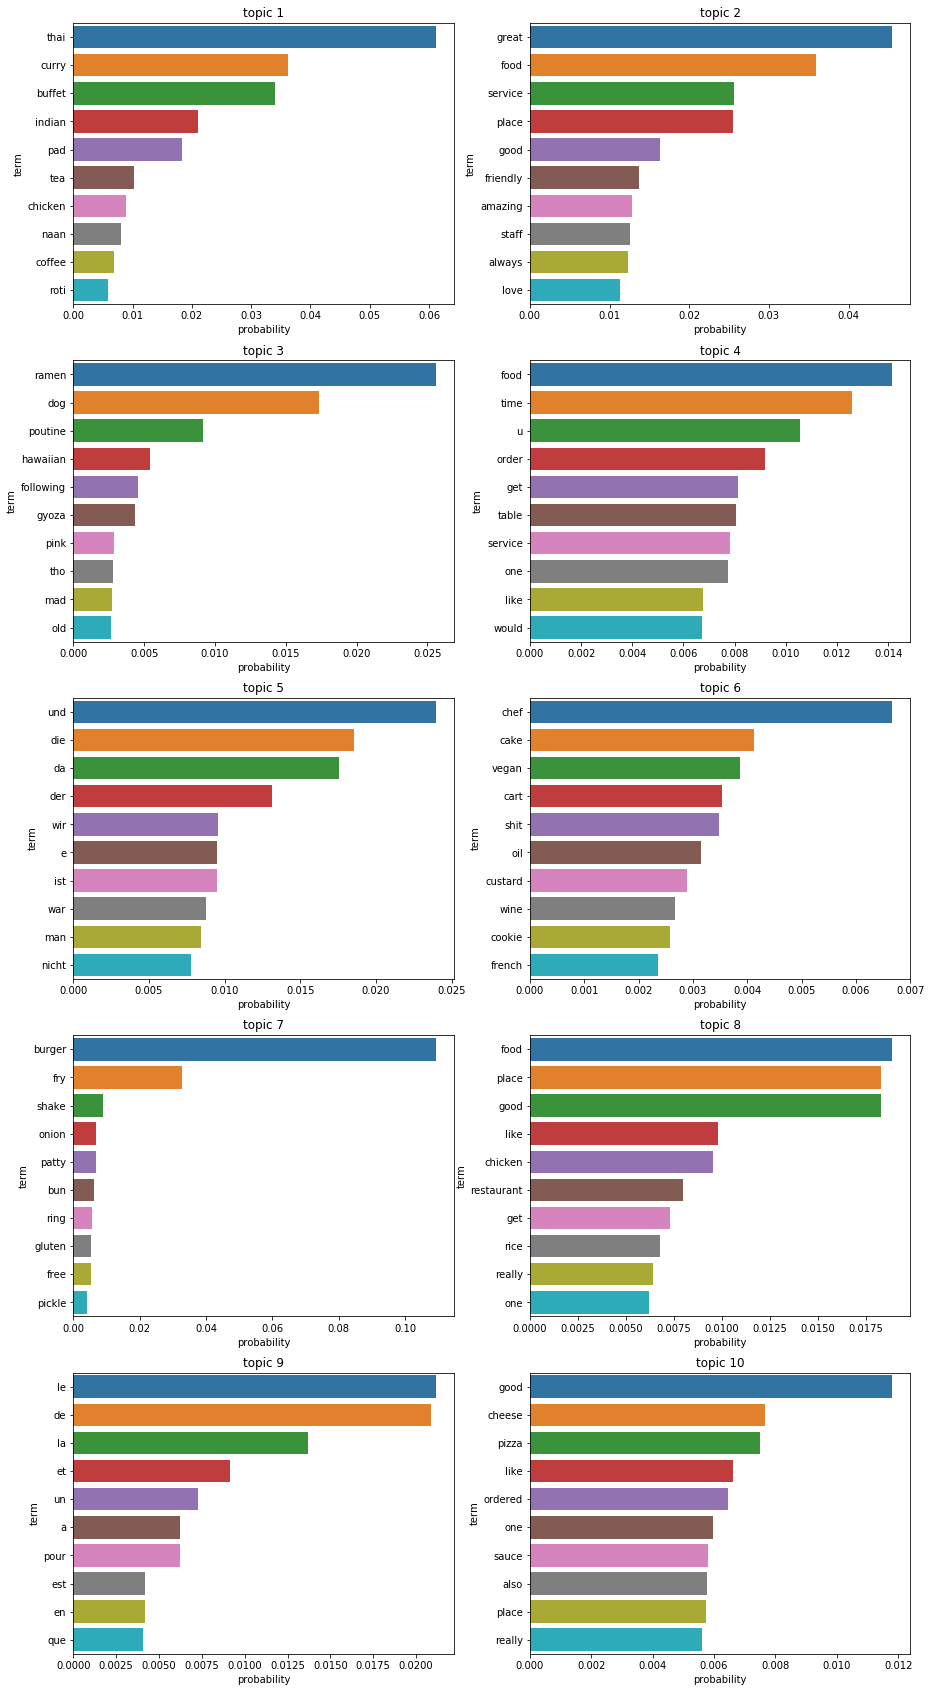

In [41]:
fiz=plt.figure(figsize=(15,30))
for i in range(10):
    df=pd.DataFrame(ldamodel.show_topic(i), columns=['term','prob']).set_index('term')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df)
    plt.xlabel('probability')
    

plt.show()

## Using the trained LDA model to get hidden topic from a new review
 

In [116]:
predict_text = predict_sampe['text'].values 

In [117]:
predict_clean = clean(predict_text[0]).split()

In [118]:
predict_vec = dictionary.doc2bow(predict_clean)

In [119]:
topic_vec = ldamodel[predict_vec]

In [120]:
word_count_array = np.empty((len(topic_vec), 2), dtype = np.object)

In [121]:
 for i in range(len(topic_vec)):
        word_count_array[i, 0] = topic_vec[i][0]
        word_count_array[i, 1] = topic_vec[i][1]

In [122]:
idx = np.argsort(word_count_array[:, 1])
idx = idx[::-1]
word_count_array = word_count_array[idx]

In [123]:
word_count_array

array([[0, 0.6500644],
       [1, 0.2832585]], dtype=object)

In [124]:
final = []
final = ldamodel.print_topics(word_count_array[0, 0], 1)

In [125]:
final

[(3, '0.148*"sushi"'),
 (9, '0.040*"chicken"'),
 (5, '0.014*"steak"'),
 (4, '0.073*"taco"'),
 (7, '0.064*"burger"'),
 (6, '0.032*"good"'),
 (8, '0.023*"u"'),
 (2, '0.111*"pizza"'),
 (0, '0.045*"great"'),
 (1, '0.025*"place"')]

## Improve the model

## 6. Using Frequency Filter to improve the model

In [68]:
from nltk import FreqDist

In [75]:
allWords = []
for wordList in doc_clean_2_1:
    allWords += wordList

In [97]:
# a frequency distribution of words (word count over the corpus)
fdist = FreqDist(allWords)
# say you want to see the top 10,000 words
k = 1000 
# unzip the words and word count tuples
top_k_words, _ = zip(*fdist.most_common(k)) 
# print the words and inspect them to see which ones you want to keep and which ones you want to disregard
print(top_k_words)

('food', 'place', 'good', 'great', 'service', 'time', 'like', 'one', 'get', 'restaurant', 'back', 'really', 'go', 'would', 'order', 'ordered', 'chicken', 'u', 'it', 'also', 'menu', 'got', 'best', 'nice', 'come', 'well', 'came', 'delicious', 'try', 'im', 'pizza', 'even', 'table', 'ive', 'love', 'little', 'sauce', 'always', 'price', 'dish', 'definitely', 'make', 'meal', 'first', 'much', 'salad', 'friendly', 'pretty', 'drink', 'staff', 'fresh', 'eat', 'went', 'burger', 'never', 'better', 'lunch', 'cheese', 'amazing', 'thing', 'could', 'people', 'wait', 'made', 'side', 'server', 'friend', 'experience', 'night', 'dinner', 'say', 'two', 'know', 'here', 'taste', 'way', 'star', 'bar', 'bit', 'minute', 'think', 'take', 'everything', 'right', 'want', 'meat', 'lot', 'rice', 'ever', '2', 'going', 'fry', 'day', 'give', 'still', 'said', 'small', 'sure', 'sandwich', 'flavor', 'sushi', 'bad', 'there', 'roll', 'location', 'special', 'hot', 'soup', 'around', 'portion', 'since', 'tried', 'recommend', 're

In [98]:
top = list(top_k_words)

In [101]:
top

['food',
 'place',
 'good',
 'great',
 'service',
 'time',
 'like',
 'one',
 'get',
 'restaurant',
 'back',
 'really',
 'go',
 'would',
 'order',
 'ordered',
 'chicken',
 'u',
 'it',
 'also',
 'menu',
 'got',
 'best',
 'nice',
 'come',
 'well',
 'came',
 'delicious',
 'try',
 'im',
 'pizza',
 'even',
 'table',
 'ive',
 'love',
 'little',
 'sauce',
 'always',
 'price',
 'dish',
 'definitely',
 'make',
 'meal',
 'first',
 'much',
 'salad',
 'friendly',
 'pretty',
 'drink',
 'staff',
 'fresh',
 'eat',
 'went',
 'burger',
 'never',
 'better',
 'lunch',
 'cheese',
 'amazing',
 'thing',
 'could',
 'people',
 'wait',
 'made',
 'side',
 'server',
 'friend',
 'experience',
 'night',
 'dinner',
 'say',
 'two',
 'know',
 'here',
 'taste',
 'way',
 'star',
 'bar',
 'bit',
 'minute',
 'think',
 'take',
 'everything',
 'right',
 'want',
 'meat',
 'lot',
 'rice',
 'ever',
 '2',
 'going',
 'fry',
 'day',
 'give',
 'still',
 'said',
 'small',
 'sure',
 'sandwich',
 'flavor',
 'sushi',
 'bad',
 'there',

In [103]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary([top])

In [104]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean_2_1]

In [105]:
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)

In [108]:
print(ldamodel.print_topics(num_topics=10, num_words=5))

[(0, '0.045*"great" + 0.045*"food" + 0.036*"place" + 0.027*"service" + 0.020*"love"'), (1, '0.025*"place" + 0.021*"like" + 0.017*"food" + 0.015*"get" + 0.014*"one"'), (2, '0.111*"pizza" + 0.049*"salad" + 0.041*"sandwich" + 0.025*"wing" + 0.024*"italian"'), (3, '0.148*"sushi" + 0.095*"roll" + 0.055*"de" + 0.055*"die" + 0.050*"le"'), (4, '0.073*"taco" + 0.044*"chip" + 0.042*"mexican" + 0.034*"salsa" + 0.032*"burrito"'), (5, '0.014*"steak" + 0.013*"dessert" + 0.013*"dish" + 0.012*"ordered" + 0.011*"meal"'), (6, '0.032*"good" + 0.026*"food" + 0.024*"place" + 0.023*"great" + 0.021*"bar"'), (7, '0.064*"burger" + 0.045*"fry" + 0.029*"cheese" + 0.022*"good" + 0.021*"egg"'), (8, '0.023*"u" + 0.021*"food" + 0.018*"order" + 0.017*"time" + 0.014*"service"'), (9, '0.040*"chicken" + 0.024*"rice" + 0.023*"good" + 0.021*"dish" + 0.020*"soup"')]


### Data visualization

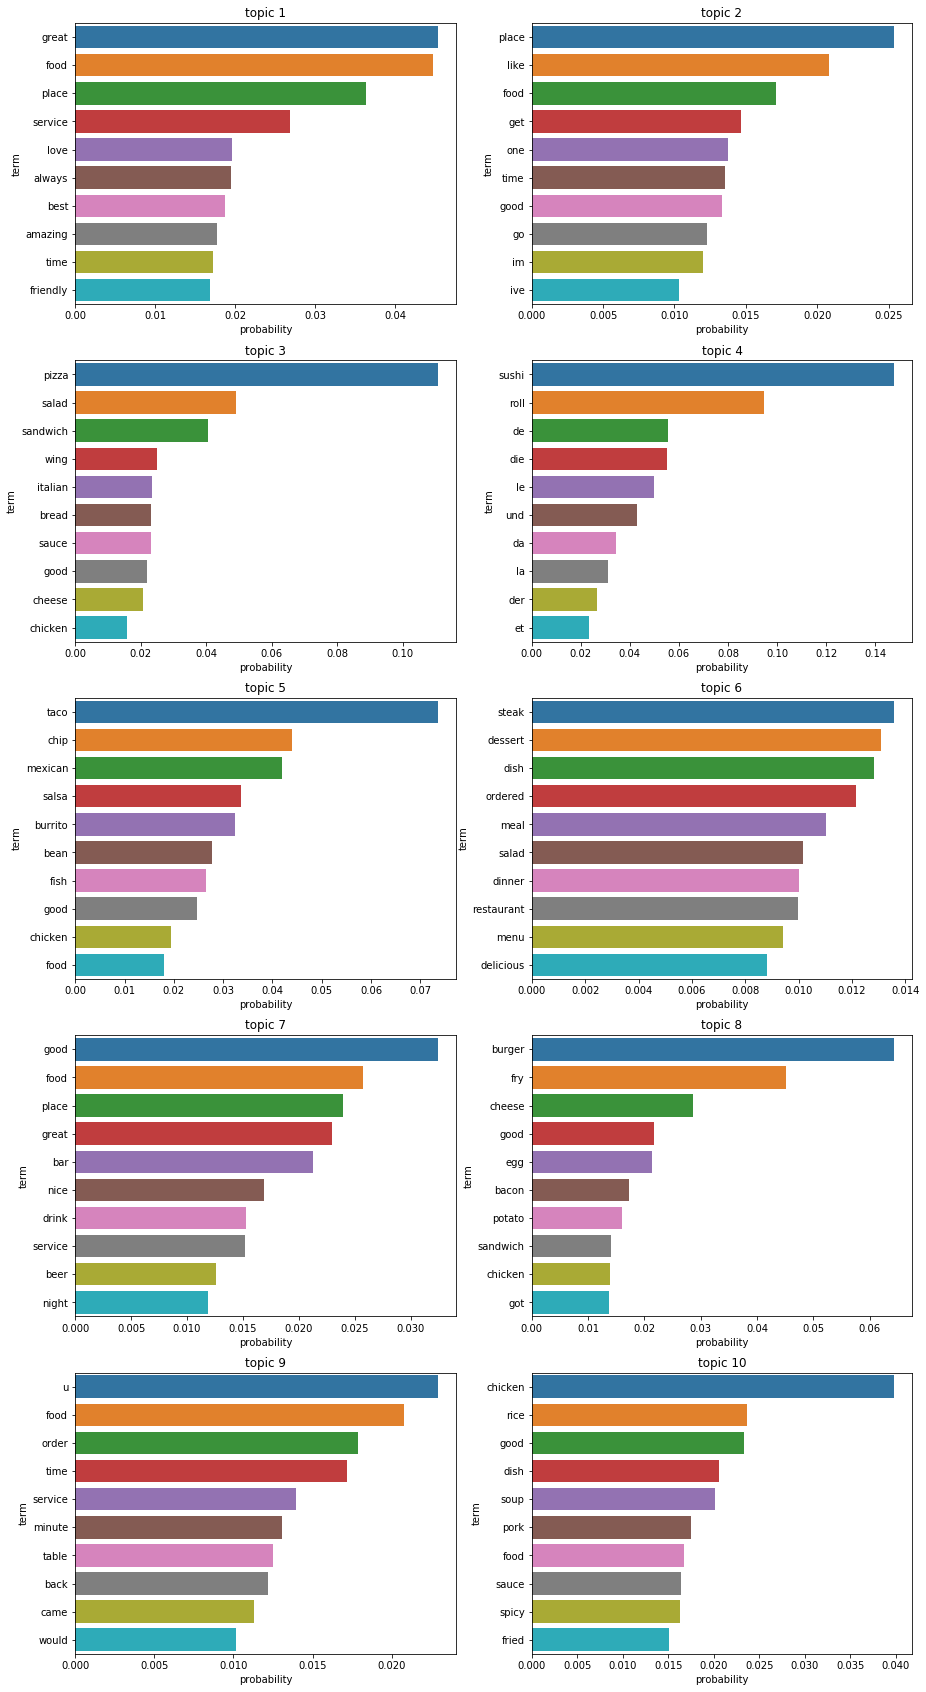

In [110]:
fiz=plt.figure(figsize=(15,30))
for i in range(10):
    df=pd.DataFrame(ldamodel.show_topic(i), columns=['term','prob']).set_index('term')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df)
    plt.xlabel('probability')
    

plt.show()

## 7. Using Part of Speech Tag Filter to improve the mode

In [36]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag
import nltk
nltk.download('averaged_perceptron_tagger')

def strip_proppers_POS(text):
    tagged = pos_tag(text) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lucyy/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [37]:
#remove proper names
preprocess = [strip_proppers_POS(doc) for doc in doc_clean_2_2]

In [38]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(preprocess)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in preprocess]

In [39]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)

In [40]:
print(ldamodel.print_topics(num_topics=10, num_words=5))

[(0, '0.035*"food" + 0.030*"great" + 0.029*"place" + 0.022*"good" + 0.018*"service"'), (1, '0.039*"de" + 0.035*"le" + 0.022*"la" + 0.018*"et" + 0.012*"un"'), (2, '0.024*"pizza" + 0.018*"burger" + 0.017*"good" + 0.014*"cheese" + 0.014*"fry"'), (3, '0.015*"like" + 0.013*"get" + 0.010*"one" + 0.009*"place" + 0.008*"im"'), (4, '0.016*"good" + 0.015*"chicken" + 0.014*"rice" + 0.013*"sushi" + 0.013*"roll"'), (5, '0.031*"und" + 0.028*"die" + 0.024*"da" + 0.018*"der" + 0.013*"ist"'), (6, '0.024*"steak" + 0.017*"wine" + 0.013*"restaurant" + 0.009*"vega" + 0.009*"experience"'), (7, '0.020*"food" + 0.015*"u" + 0.013*"time" + 0.012*"service" + 0.011*"order"'), (8, '0.014*"salad" + 0.012*"dish" + 0.011*"dessert" + 0.009*"chicken" + 0.009*"delicious"'), (9, '0.053*"egg" + 0.051*"breakfast" + 0.033*"coffee" + 0.029*"buffet" + 0.028*"chinese"')]


### Data visualization

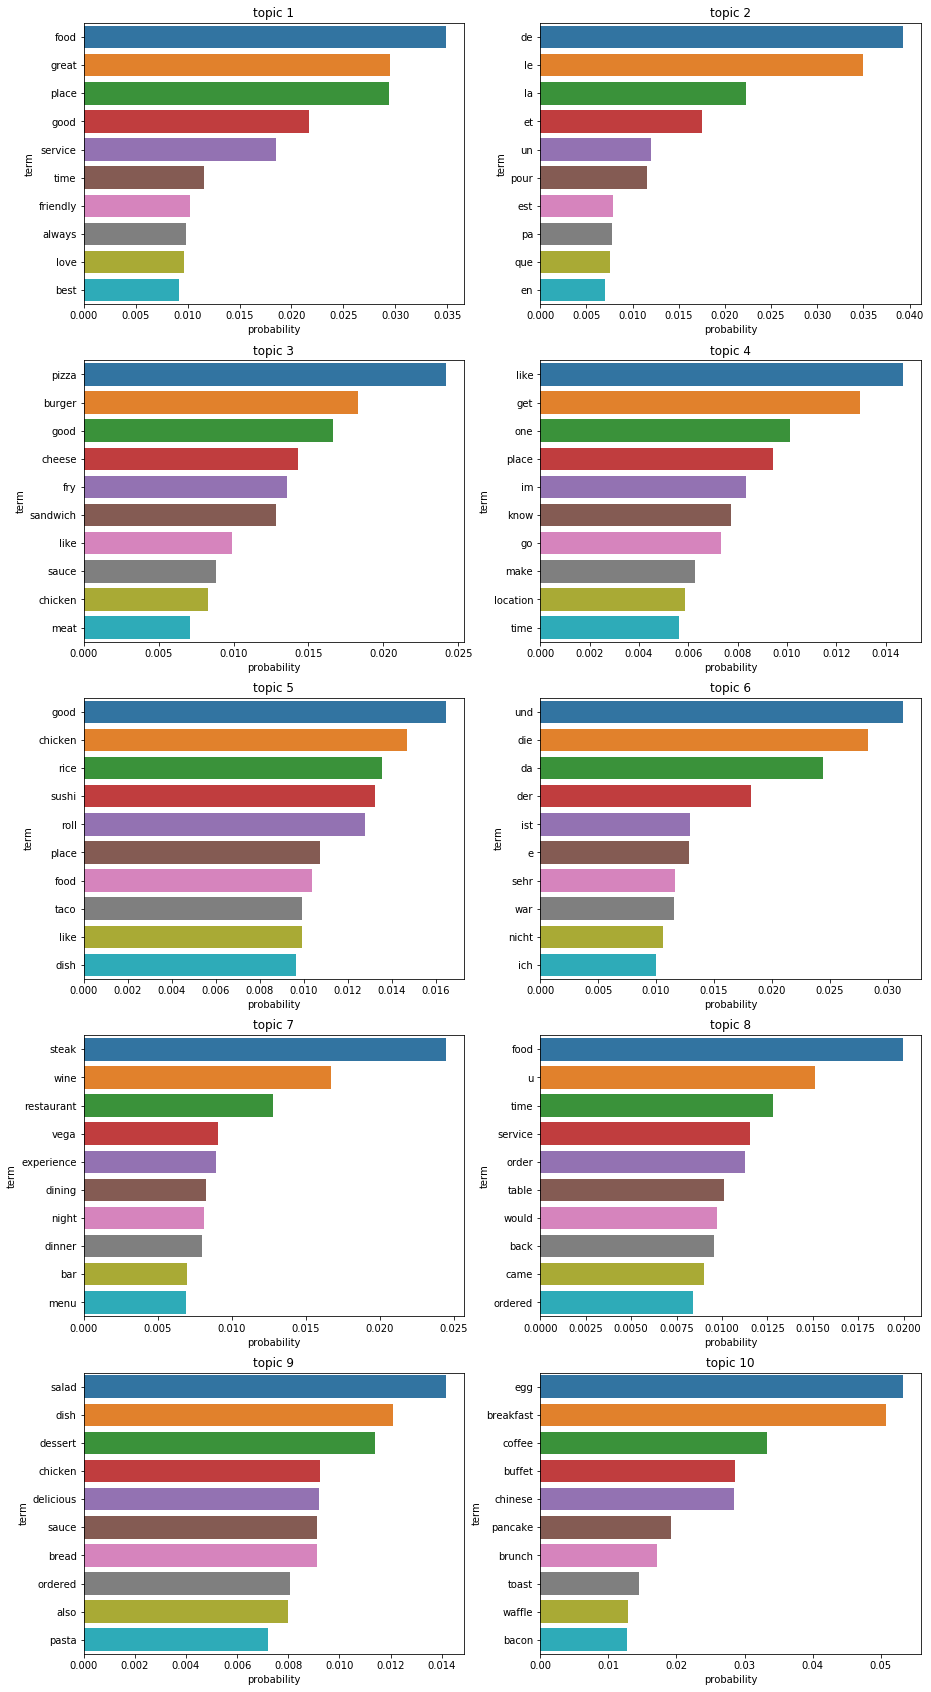

In [41]:
fiz=plt.figure(figsize=(15,30))
for i in range(10):
    df=pd.DataFrame(ldamodel.show_topic(i), columns=['term','prob']).set_index('term')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df)
    plt.xlabel('probability')
    

plt.show()

# License
This project is licensed under the MIT License - see the file [LICENSE.md](https://github.com/lucylucyyangyang/Final-Project-CODE) for details

# Citation
Stack overflow, Understanding LDA / topic modelling — too much topic overlap [Source code](https://stackoverflow.com/questions/46326173/understanding-lda-topic-modelling-too-much-topic-overlap)

Stack overflow, Reading file using relative path in python project [Source code](https://stackoverflow.com/questions/40416072/reading-file-using-relative-path-in-python-project/40416154)

Stack overflow, How to predict the topic of a new query using a trained LDA model using gensim? [Source code](https://stackoverflow.com/questions/16262016/how-to-predict-the-topic-of-a-new-query-using-a-trained-lda-model-using-gensim)

Brandon Rose, Document Clustering with Python [Source code](http://brandonrose.org/clustering)

Shivam Bansal, Beginners Guide to Topic Modeling in Python [Source code](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)

StackExchange, Calculating precision and recall for LDA [Source code](https://stats.stackexchange.com/questions/185983/calculating-precision-and-recall-for-lda)

James Huang, Improving Restaurants by Extracting Subtopics from Yelp Reviews [Source code](https://www.yelp.com/html/pdf/YelpDatasetChallengeWinner_ImprovingRestaurants.pdf)